# Converting STLs to Voxels and Back

It turns out that creating a triangular mesh is quite a difficult task. Given our time constraints, it might be sensible to go down the more explored path of 3D object generation with voxels. Voxels can be thought of as "3D pixels". They are not as variable as triangular meshes and so are easier data objects to work with and much preexisting research is already available.

This notebook explores some of the utilities required in a voxel-based solution.

1. Converting STLs to Voxels
2. Plotting Voxels
3. Converting Voxels to STLs

Note that the functions created and used in this notebook are not necessarily supported in the 3d Form source and are primarily used for the purposes of demonstration.

## Setup

In [1]:
import os
import numpy as np


# autoreload changed modules!!
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# import data
import env
from data.thingi10k import Thingi10k
#from data.stl import save_vectors_as_stl
#from data.stl import plot_mesh

thingi = Thingi10k.init10()

## STL to Voxels

For this we need the binvox.exe program downloadable from http://www.patrickmin.com/binvox/

### Binvox Demonstration

In [3]:
import subprocess

def make_binvox(stl_path):
    binvox_path = stl_path.replace('.stl', '.binvox')
    subprocess.run(["../src/data/binvox", stl_path])
    print(binvox_path, os.path.exists(binvox_path))
    return binvox_path

stl_path = thingi.get_stl_path(0)
binvox_path = make_binvox(stl_path)

/home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/779964.binvox True


In [4]:
# the magical voxelization utility!
from data import binvox_rw

In [5]:
def read_3D(path):
    with open(path, 'rb') as f:
        m1 = binvox_rw.read_as_3d_array(f)
    return m1
    #return (np.reshape(downSampling.downsample_cube2(m1.data, 4), (32, 32, 32, 1)) - 0.5) / 0.5
    
vox = read_3D(binvox_path)
# dimensions are 256 by 256; each voxel is represented by a TRUE in the array
print(vox.data.shape)
vox.data[0:2]

(256, 256, 256)


array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [6]:
np.reshape(vox.data, [256, 256, 256, 1]).shape

(256, 256, 256, 1)

In [7]:
vox.dims

[256, 256, 256]

### Controlling Voxel Object Dimension with Binvox

In [53]:
import subprocess

stl_path = thingi.get_stl_path(1)

def make_binvox_with_size(stl_path, size):
    # binvox dim is controlled by -d arg
    # -d: specify voxel grid size (default 256, max 1024)(no max when using -e)
    # -cb centers object in bounding box
    binvox_path = stl_path.replace('.stl', '.binvox').replace('.STL', '.binvox')
    # binvox will not overwrite a previously existing binvox file and will instead
    # create a new one with <filename>_N.binvox where N is some number based on how
    # many matches it finds
    if os.path.exists(binvox_path):
        os.remove(binvox_path)
    subprocess.run(["../src/data/binvox", "-cb", "-d", str(size), stl_path])
    print(binvox_path, os.path.exists(binvox_path))
    return binvox_path

binvox_path = make_binvox_with_size(stl_path, 64)
    
vox = read_3D(binvox_path)
vox.data.shape

/home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/1131717.binvox True


(64, 64, 64)

### Plotting a Binvox Object

We can use matplotlib's 3d plots to plot the voxel object's data.

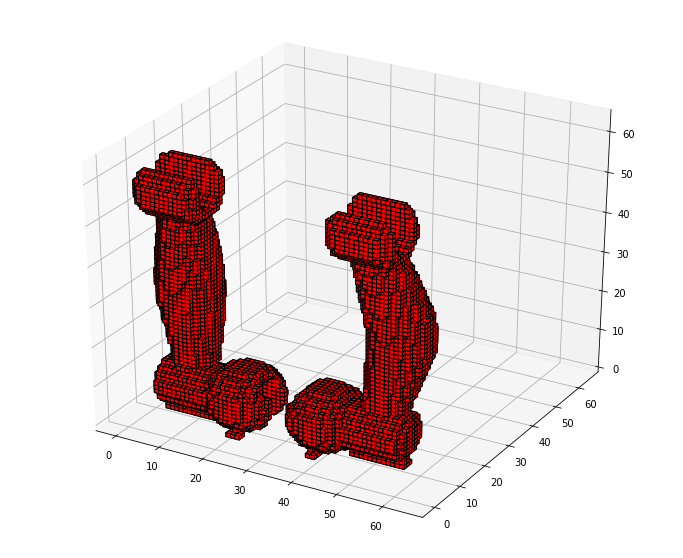

In [9]:
# https://matplotlib.org/gallery/mplot3d/voxels.html

# takes a really long time if dims are large

import matplotlib.pyplot as plt
import numpy as np

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

def plot_3d_voxels(vox_data):
    fig = plt.figure(figsize=(12,10))
    ax = fig.gca(projection='3d')
    ax.voxels(vox_data, facecolors='red', edgecolor='k')
    plt.show()
    
plot_3d_voxels(vox.data)

In [10]:
# there is a second func used to conserve memory
# hopefully this is not needed when we reduce dims
vox2 = None
with open(binvox_path, 'rb') as f:
    vox2 = binvox_rw.read_as_coord_array(f)
print(vox2.data.shape)
vox2.data

(3, 14513)


array([[ 0.40942383,  0.42480469,  0.42504883, ..., 59.55029297,
        59.56542969, 59.56567383],
       [13.        , 12.        , 13.        , ..., 14.        ,
        12.        , 13.        ],
       [26.203125  , 27.1875    , 27.203125  , ..., 35.21875   ,
        36.1875    , 36.203125  ]])

In [11]:
print(vox2.data[0].shape)

(14513,)


## Voxels to STLs

Using scikit learn's implementation of the "Marching Cubes" algorithm to convert voxels to a polygon mesh: http://scikit-image.org/docs/dev/auto_examples/edges/plot_marching_cubes.html#sphx-glr-auto-examples-edges-plot-marching-cubes-py

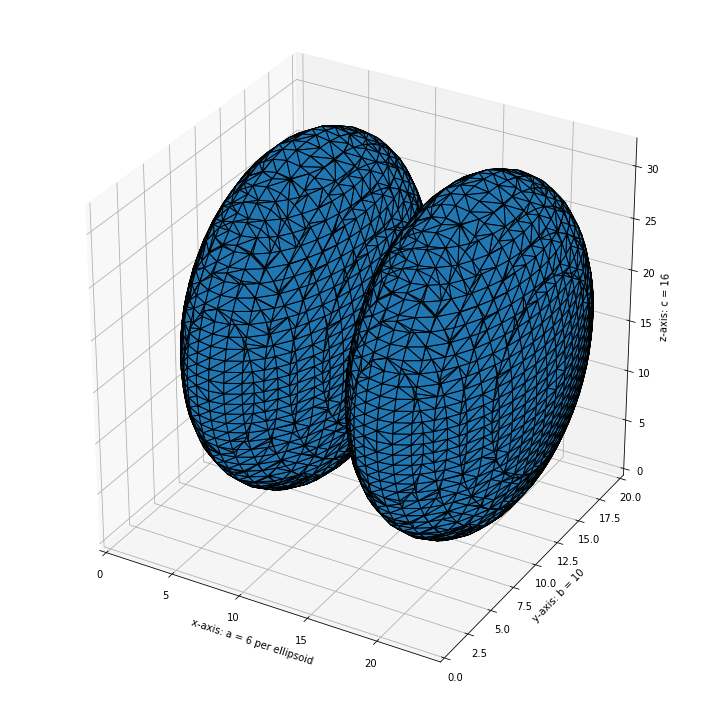

In [12]:
#
# This is an example from the abovel link not the voxels from the previous section
#

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid


# Generate a level set about zero of two identical ellipsoids in 3D
ellip_base = ellipsoid(6, 10, 16, levelset=True)
ellip_double = np.concatenate((ellip_base[:-1, ...],
                               ellip_base[2:, ...]), axis=0)

# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes_lewiner(ellip_double, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 24)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 20)  # b = 10
ax.set_zlim(0, 32)  # c = 16

plt.tight_layout()
plt.show()

In [13]:
# what does the input to marching cubes look like?
print(ellip_double.shape)
ellip_double[:2]

(27, 23, 35)


array([[[2.70001736, 2.57111111, 2.45001736, ..., 2.45001736,
         2.57111111, 2.70001736],
        [2.49001736, 2.36111111, 2.24001736, ..., 2.24001736,
         2.36111111, 2.49001736],
        [2.30001736, 2.17111111, 2.05001736, ..., 2.05001736,
         2.17111111, 2.30001736],
        ...,
        [2.30001736, 2.17111111, 2.05001736, ..., 2.05001736,
         2.17111111, 2.30001736],
        [2.49001736, 2.36111111, 2.24001736, ..., 2.24001736,
         2.36111111, 2.49001736],
        [2.70001736, 2.57111111, 2.45001736, ..., 2.45001736,
         2.57111111, 2.70001736]],

       [[2.33890625, 2.21      , 2.08890625, ..., 2.08890625,
         2.21      , 2.33890625],
        [2.12890625, 2.        , 1.87890625, ..., 1.87890625,
         2.        , 2.12890625],
        [1.93890625, 1.81      , 1.68890625, ..., 1.68890625,
         1.81      , 1.93890625],
        ...,
        [1.93890625, 1.81      , 1.68890625, ..., 1.68890625,
         1.81      , 1.93890625],
        [2.1

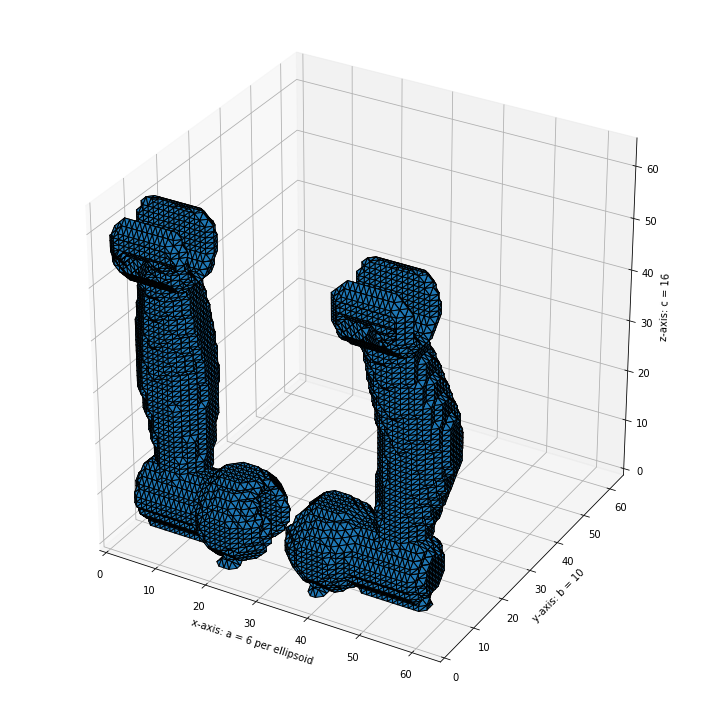

In [14]:
#
# trying now with voxel data
#

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure

# Use marching cubes to obtain the surface mesh
verts, faces, normals, values = measure.marching_cubes_lewiner(vox.data, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, vox.dims[0])
ax.set_ylim(0, vox.dims[1])
ax.set_zlim(0, vox.dims[2])

plt.tight_layout()
plt.show()

In [15]:
# and look we have vectors! 
print(verts[faces].shape)
verts[faces][:2]

(18724, 3, 3)


array([[[1.000000e+00, 9.000000e+00, 2.600000e+01],
        [1.000000e+00, 1.000000e+01, 2.500000e+01],
        [2.220446e-16, 1.000000e+01, 2.600000e+01]],

       [[2.220446e-16, 1.000000e+01, 2.700000e+01],
        [1.000000e+00, 9.000000e+00, 2.700000e+01],
        [2.220446e-16, 1.000000e+01, 2.600000e+01]]], dtype=float32)

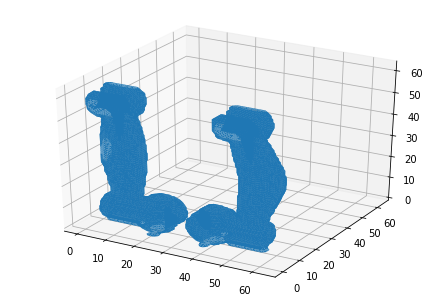

In [16]:
# we can save to STL
from data.stl import save_vectors_as_stl
from data.stl import plot_mesh


save_vectors_as_stl(verts[faces], 'stl_to_voxel_to_stl.stl')
plot_mesh(verts[faces])

In [17]:
# it worked!

## Bringing It All Together

Now that we can,

1. Convert STL to Binvox
2. Plot Binvox
3. Convert Binvox to STL

We combine these steps into a single pipeline. We will do this with a fun example: the bear.

In [32]:
from data import EXTERNAL_DIR
THE_BEAR = os.path.join(EXTERNAL_DIR, 'Bear.stl')
assert os.path.exists(THE_BEAR)

(1110, 3, 3)


NotImplementedError: memoryview: unsupported format <f

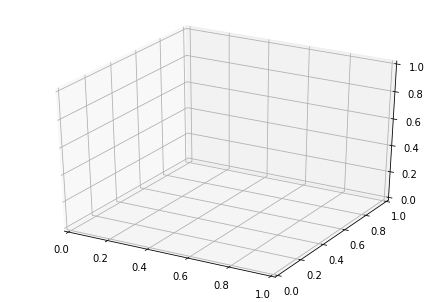

In [38]:
from data.stl import plot_mesh, read_mesh_vectors
mesh = read_mesh_vectors(THE_BEAR)
print(mesh.data.shape)
plot_mesh(mesh.data)

In [57]:
binvox_path = make_binvox_with_size(THE_BEAR, 64)
print(binvox_path)
vox = read_3D(binvox_path)
vox.data.shape

/home/jcworkma/jack/3d-form/src/../data/external/Bear.binvox True
/home/jcworkma/jack/3d-form/src/../data/external/Bear.binvox


(64, 64, 64)

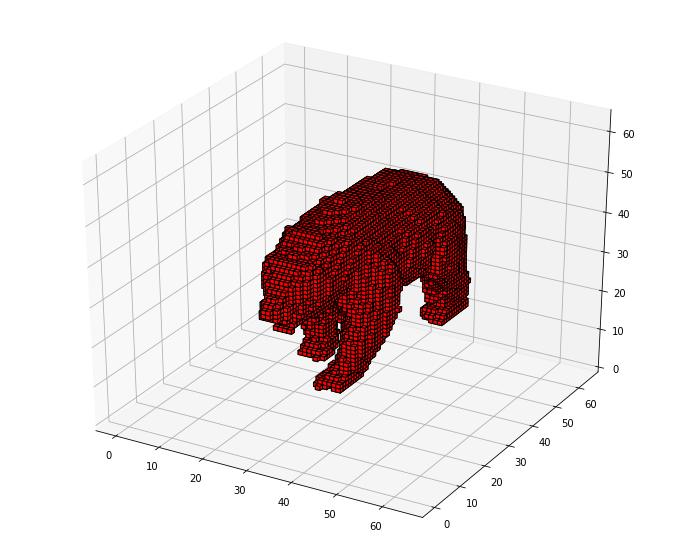

In [58]:
plot_3d_voxels(vox.data)

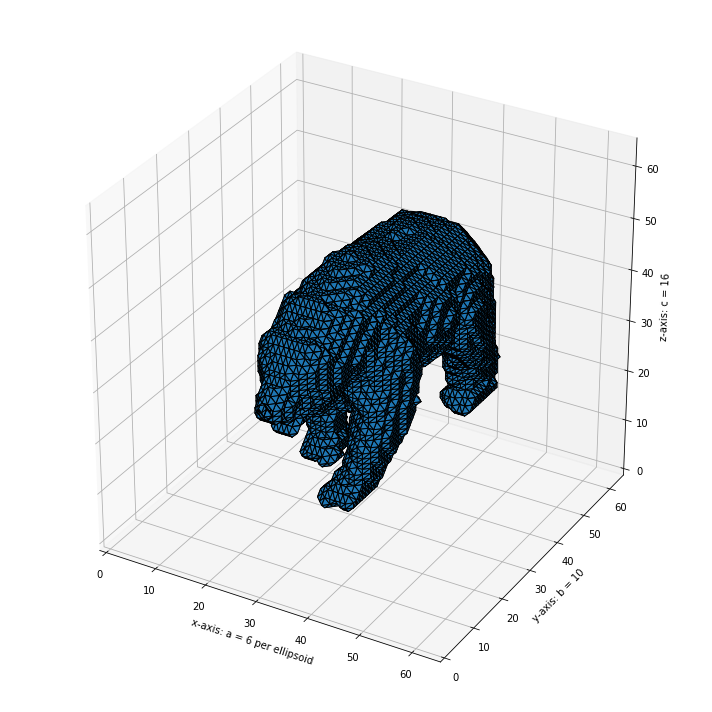

In [59]:
#
# trying now with voxel data
#

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure

# Use marching cubes to obtain the surface mesh
verts, faces, normals, values = measure.marching_cubes_lewiner(vox.data, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, vox.dims[0])
ax.set_ylim(0, vox.dims[1])
ax.set_zlim(0, vox.dims[2])

plt.tight_layout()
plt.show()

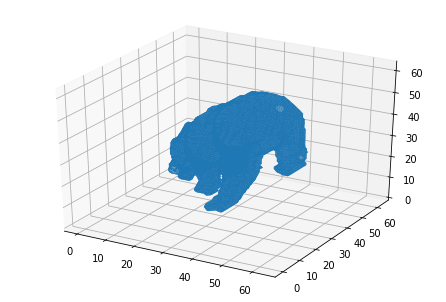

In [60]:
# we can save to STL
from data.stl import save_vectors_as_stl
from data.stl import plot_mesh


save_vectors_as_stl(verts[faces], 'stl_to_voxel_to_stl_bear.stl')
plot_mesh(verts[faces])

### How much do we lose with Dim=32?

In [54]:
binvox_path = make_binvox_with_size(THE_BEAR, 32)
print(binvox_path)
vox = read_3D(binvox_path)
vox.data.shape

/home/jcworkma/jack/3d-form/src/../data/external/Bear.binvox True
/home/jcworkma/jack/3d-form/src/../data/external/Bear.binvox


(32, 32, 32)

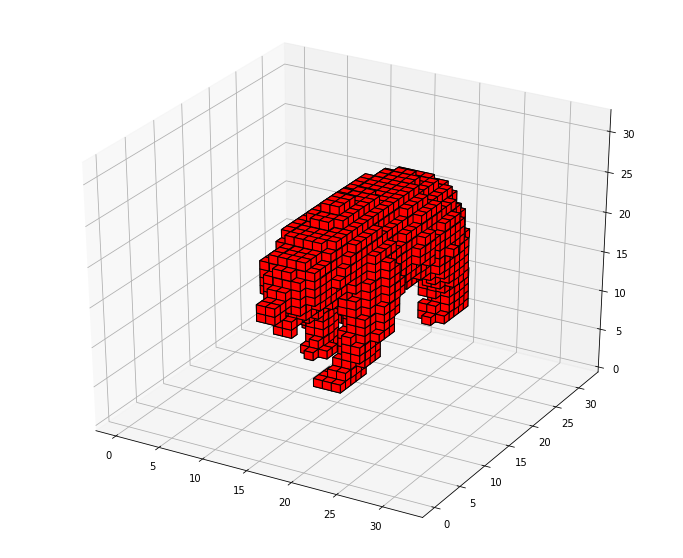

In [55]:
plot_3d_voxels(vox.data)

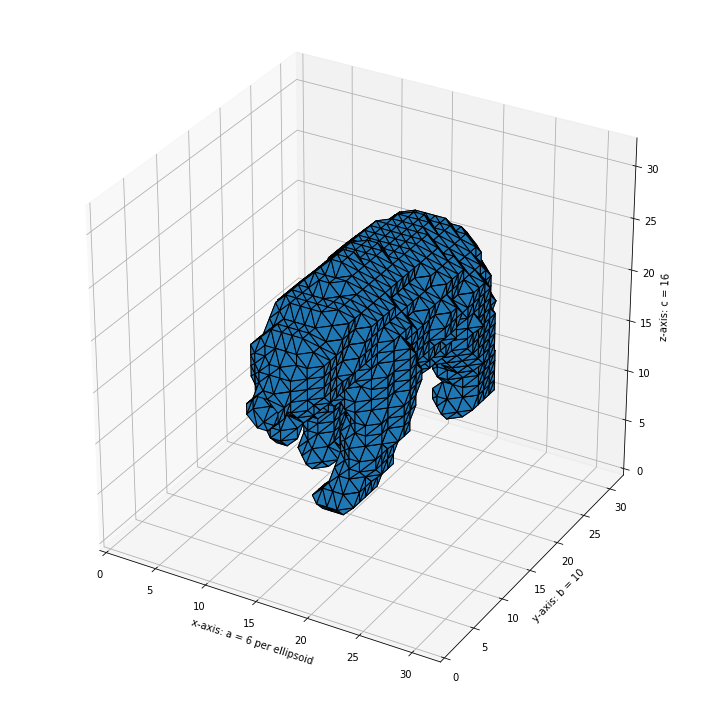

In [56]:
#
# trying now with voxel data
#

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure

# Use marching cubes to obtain the surface mesh
verts, faces, normals, values = measure.marching_cubes_lewiner(vox.data, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, vox.dims[0])
ax.set_ylim(0, vox.dims[1])
ax.set_zlim(0, vox.dims[2])

plt.tight_layout()
plt.show()